In [12]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import scipy.stats as stats
import netgraph

import seaborn as sns
import json
import openai
import random
import os
import collections
import copy
from utils import get_response, summarize_reasons


MEDIUM_SIZE = 28
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def generate_individuals(n):
    profiles = []

    hobbies = ['reading', 'writing', 'cooking']
    colors = ['red', 'orange', 'yellow', 'green']
    
    locations = ['New York City', 'Boston', 'Washington DC']

    for i in range(n):
        profile = {
            'name' : i,
            'hobby' : random.choice(hobbies),
            'favorite color' : random.choice(colors),
            'location' : random.choice(locations)
        }

        profiles.append(profile)

    with open('outputs/profiles.jsonl', 'w+') as f:
        [f.write(json.dumps(profile) + '\n') for profile in profiles]


def network_growth(n0, temperature, model, environment, role, method='llm', cot=False, profiles_filename='outputs/profiles.jsonl', mutual_acceptance=False):
    with open(profiles_filename) as f:
        profiles = f.read().splitlines()
        profiles = [json.loads(profile) for profile in profiles]

    profiles = profiles[:n0]

    G = nx.Graph()
    G.add_nodes_from(range(n0))

    Gs = []
    results = []
    total_requests = 0
    num_accepted_requests = 0

    for t in range(n0):

        if method == 'llm':
            result = select_neighbor(G, t, profiles, temperature, model=model, environment=environment, role=role, cot=cot, mutual_acceptance=mutual_acceptance)

            if result:
                for r in result:
                    v = r['name']
                    if r.get('accepted', False):
                        G.add_edge(t, v, similarity=r['similarity'])
                        num_accepted_requests += 1
                    total_requests += 1
                results.append(result)
        elif method in ['random', 'homophilous', 'heterophilous']:
            if method == 'random':
                new_nodes = random.sample(list(set(G.nodes()) - set([t])), 4)
            elif method == 'homophilous':
                new_nodes = list(sorted([v for v in G.nodes() if v != t], key=lambda v: len(set(profile_set(profiles[t])) & profile_set(profiles[v])), reverse=True))[:4]
            elif method == 'heterophilous':
                new_nodes = list(sorted([v for v in G.nodes() if v != t], key=lambda v: len(set(profile_set(profiles[t])) & profile_set(profiles[v]))))[:4]
            
            for v in new_nodes:
                intersection = list(set(profile_set(profiles[t])) & profile_set(profiles[v]))
                union = list(set(profile_set(profiles[t])) | profile_set(profiles[v]))
                similarity = len(intersection)
                G.add_edge(t, v, intersection=intersection, union=union, similarity=similarity)
                num_accepted_requests += 1
                total_requests += 1
            
            results.append([{'name' : v, 'intersection' : intersection, 'union' : union, 'similarity' : similarity} for v in new_nodes])
       
        Gs.append(G.copy())

    return Gs, results, num_accepted_requests / total_requests * 100

def profile_set(p):
    temp = []
    for k, v in p.items():
        if k == 'name':
            continue
        else:
            temp.append(v)

    return set(temp)

def select_neighbor(G, t, profiles, temperature, model, environment, role, cot, mutual_acceptance=False):
    candidate_profiles = []
    for v in G.nodes():
        if v != t:          
            candidate_profiles.append(profiles[v])
    
    if cot: 
        output_format = f"""
    {{
        "reason" : reason for selecting the person,
        "name" : name of the person you selected
    }}
        """
    else:
        output_format = f"""
    {{
        "name" : name of the person you selected,
        "reason" : reason for selecting the person
    }}
        """

    prompt = f"""
    # Task
    {f'You are in a {environment}.' if environment else ''}Your task is to select a person to be {role} with.
   
    # Profile
    Your profile is given below after chevrons:
    <PROFILE>
    {json.dumps(profiles[t])}
    </PROFILE>

    # Candidate Profiles
    The cadidate profiles to be friends with are given below after chevrons:

    <PROFILES>
    {json.dumps(candidate_profiles)}
    </PROFILES>

    # Output
    The output should be given a list of JSON objects with the following structure

    [
        {output_format}, ...
    ]

    # Notes
    * The output must be a list of JSON objects ranked in the order of preference.
    * You can make at most 4 selections.
    * Your output mush be only the JSON objects and nothing else.

    ```json
    """   

    for i in range(10):
        try:
            ans = get_response(prompt, model, temperature)
            # import pdb; pdb.set_trace()
            try:
                results = json.loads(ans.split('```')[0])
            except:
                results = json.loads(ans.split('```json')[1].split('```')[0])

            filtered_results = []
            for result in results:
                if result['name'] in G.nodes():
                    v = result['name']
                    result['intersection'] = list(profile_set(profiles[t]) & profile_set(profiles[v]))
                    result['union'] = list(profile_set(profiles[t]) | profile_set(profiles[v]))
                    result['similarity'] = len(result['intersection'])
                    filtered_results.append(result)

            break            
        except Exception as e:
            print(e)

    for r in filtered_results:
        if mutual_acceptance:
            prompt = f"""
            # Task
            {f'You are in a {environment}.' if environment else ''}. You receive a request to be {role} with a person.
        
            # Profile
            Your profile is given below after chevrons:
            <PROFILE>
            {json.dumps(profiles[t])}
            </PROFILE>

            # Candidate Profile
            The candidate profile to be friends with is given below after chevrons:
            <PROFILE>
            {json.dumps(profiles[r["name"]])}
            </PROFILE>

            # Output
            The output should be a JSON object with the following structure

            {{
                "accept" : true/false,
                "reason" : reason for accepting or rejecting the request
            }}

            # Notes
            * The output must be a JSON object.
            * You can only accept or reject the request.
            * Your output mush be only the JSON object and nothing else.

            ```json
            """

            for i in range(10):
                try:
                    ans = get_response(prompt, model, temperature)
                    try:
                        results = json.loads(ans.split('```')[0])
                    except:
                        results = json.loads(ans.split('```json')[1].split('```')[0])

                except Exception as e:
                    print(e)

                if results['accept']:
                    # set result accepted to true
                    r['accepted'] = True
                    r['acceptance_reason'] = results['reason']
                    break
        else:
            r['accepted'] = True
            r['acceptance_reason'] = 'Mutual acceptance is not enabled'

    print(f'Node: {t}, Results: {filtered_results}')

    return filtered_results


def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, method, model, environment, role, cot=False, profiles_filename='outputs/profiles.jsonl', mutual_acceptance=False):
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')

                    Gs, reasons, mutual_acceptance_probability = network_growth(n, temperature=temperature, method=method, model=model, environment=environment, role=role, cot=cot, profiles_filename=profiles_filename, mutual_acceptance=mutual_acceptance)

                    temp = {
                        'n' : n,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_dicts(G) for G in Gs],
                        'reasons' : reasons,
                        'mutual_acceptance_probability' : mutual_acceptance_probability
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, communities=None, palette=None, use_netgraph=True, ego_network=False):

    if not use_netgraph:
        pos = nx.spring_layout(G, weight='similarity')
    
        if communities:
            for i, community in enumerate(communities):
                nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_size=20, node_color=palette[i], ax=ax)
        else:
            nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=20, node_color='#d35400', ax=ax)

        edge_widths = [1 + G.edges[u, v]['similarity'] for (u, v) in G.edges()]

        nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), width=edge_widths, edge_color='#34495e', alpha=0.5, ax=ax)
    elif use_netgraph and not ego_network:
        node2community = {node: i for i, community in enumerate(communities) for node in community}
        node_color = {node : palette[node2community[node]] for node in G.nodes()}
        edge_widths = {(u, v) : (1 + G.edges[u, v]['similarity']) * 0.5 for (u, v) in G.edges()}

        # netgraph.Graph(G, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_width=edge_widths, edge_color='#34495e', edge_layout='bundled', edge_layout_kwargs=dict(k=2000), ax=ax)
        netgraph.Graph(G, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_width=edge_widths, edge_color='#34495e', ax=ax)

    elif use_netgraph and ego_network:
        ego_net = nx.ego_graph(G, list(G.nodes())[0], radius=1)

        node2community = {node: i for i, community in enumerate(communities) for node in community}

        node_color = {node : palette[node2community[node]] for node in ego_net.nodes()}
        node_size = {}

        for node in ego_net.nodes():
            if node == list(G.nodes())[0]:
                node_size[node] = 5
            else:
                node_size[node] = 2.5

        edge_widths = {(u, v) : (1 + ego_net.edges[u, v]['similarity']) * 0.5 for (u, v) in ego_net.edges()}
        netgraph.Graph(ego_net, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=node_size, edge_width=edge_widths, edge_color='#34495e', ax=ax)

    ax.set_axis_off()


def analyze_experiments(filename):

    palette = ['#d35400', '#34495e', '#2980b9', '#e67e22', '#f1c40f', '#7f8c8d', '#27ae60', '#16a085', '#bdc3c7', '#1abc9c', '#2ecc71', '#3498db', '#9b59b6', '#8e44ad', '#ecf0f1']

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []


    for line in lines:
        data.append(json.loads(line))

    edge_similarity_distributions = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list) }
    wasserstein_distance = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list) }
    louvain_communities = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list) }
    louvain_modularity = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list) }
    location_assortativities = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list)}
    favorite_color_assortativities = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list)}
    hobby_assortativities = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list)}

    final_graphs = collections.defaultdict(list)

    with open('outputs/profiles.jsonl') as f:
        profiles = f.read().splitlines()
        profiles = [json.loads(profile) for profile in profiles]

    profiles_dict = {str(profile['name']) : profile for profile in profiles}

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.from_dict_of_dicts(graph)
            
            nx.set_node_attributes(G, profiles_dict)

            G.remove_edges_from(nx.selfloop_edges(G))
            # G.remove_nodes_from(list(nx.isolates(G)))

            Gs.append(G)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        louvain_communities['llm'][d['n'], d['temperature']].append(nx.algorithms.community.louvain_communities(Gs[-1], weight='similarity'))
        louvain_modularity['llm'][d['n'], d['temperature']].append(nx.algorithms.community.modularity(Gs[-1], louvain_communities['llm'][d['n'], d['temperature']][-1], weight='similarity'))


        final_graphs[d['n'], d['temperature']].append((Gs[-1], louvain_communities['llm'][d['n'], d['temperature']][-1]))


        G_homophilous = network_growth(d['n'], d['temperature'], method='homophilous')[0][-1]
        G_heterophilous = network_growth(d['n'], d['temperature'], method='heterophilous')[0][-1]
        G_random = network_growth(d['n'], d['temperature'], method='random')[0][-1]

        nx.set_node_attributes(G_homophilous, {int(profile['name']) : profile for profile in profiles})
        nx.set_node_attributes(G_heterophilous, {int(profile['name']) : profile for profile in profiles})
        nx.set_node_attributes(G_random, {int(profile['name']) : profile for profile in profiles})

        ax[0].set_title(f'Temperature = {d["temperature"]}')
        
        draw_graph(Gs[-1], ax=ax[0], communities=louvain_communities['llm'][d['n'], d['temperature']][-1], palette=palette)

        edge_similarity_distribution = [G.edges[u, v]['similarity'] for (u, v) in Gs[-1].edges()]
        edge_similarity_distribution_homophilous = [G_homophilous.edges[u, v]['similarity'] for (u, v) in G_homophilous.edges()]
        edge_similarity_distribution_heterophilous = [G_heterophilous.edges[u, v]['similarity'] for (u, v) in G_heterophilous.edges()]
        edge_similarity_distribution_random = [G_random.edges[u, v]['similarity'] for (u, v) in G_random.edges()]

        wasserstein_distance['homophilous'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_homophilous))
        wasserstein_distance['heterophilous'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_heterophilous))
        wasserstein_distance['random'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_random))

        print(f'Temperature: {d["temperature"]} T-test Test Homophilous: {stats.ttest_ind(edge_similarity_distribution, edge_similarity_distribution_homophilous, equal_var=False, alternative="less")}')
        print(f'Temperature: {d["temperature"]} T-test Test Random: {stats.ttest_ind(edge_similarity_distribution, edge_similarity_distribution_random, equal_var=False, alternative="two-sided")}')
    

        edge_similarity_distributions['homophilous'][d['n'], d['temperature']].extend(edge_similarity_distribution_homophilous)
        edge_similarity_distributions['heterophilous'][d['n'], d['temperature']].extend(edge_similarity_distribution_heterophilous)
        edge_similarity_distributions['random'][d['n'], d['temperature']].extend(edge_similarity_distribution_random)
        edge_similarity_distributions['llm'][d['n'], d['temperature']].extend(edge_similarity_distribution)

        louvain_communities['homophilous'][d['n'], d['temperature']].append(nx.algorithms.community.louvain_communities(G_homophilous, weight='similarity'))
        louvain_communities['random'][d['n'], d['temperature']].append(nx.algorithms.community.louvain_communities(G_random, weight='similarity'))

        louvain_modularity['homophilous'][d['n'], d['temperature']].append(nx.algorithms.community.modularity(G_homophilous, louvain_communities['homophilous'][d['n'], d['temperature']][-1], weight='similarity'))
        louvain_modularity['random'][d['n'], d['temperature']].append(nx.algorithms.community.modularity(G_random, louvain_communities['random'][d['n'], d['temperature']][-1], weight='similarity'))

        location_assortativities['homophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_homophilous, 'location'))
        location_assortativities['heterophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_heterophilous, 'location'))
        location_assortativities['random'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_random, 'location'))
        location_assortativities['llm'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(Gs[-1], 'location'))

        favorite_color_assortativities['homophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_homophilous, 'favorite color'))
        favorite_color_assortativities['heterophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_heterophilous, 'favorite color'))
        favorite_color_assortativities['random'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_random, 'favorite color'))
        favorite_color_assortativities['llm'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(Gs[-1], 'favorite color'))

        hobby_assortativities['homophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_homophilous, 'hobby'))
        hobby_assortativities['heterophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_heterophilous, 'hobby'))
        hobby_assortativities['random'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_random, 'hobby'))
        hobby_assortativities['llm'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(Gs[-1], 'hobby'))


        sns.histplot(edge_similarity_distribution, ax=ax[1], label='LLM', color='#d35400', binwidth=0.45, discrete=True, stat='density')
        ax[1].xaxis.set_major_locator(mticker.MultipleLocator(1))
        
        ax[1].set_xlabel('Number of Common Attributes')
        ax[1].set_ylabel('Probability of Edge Creation')
        ax[1].set_ylim(0, 0.75)
        ax[1].legend()

        fig.tight_layout()
        fig.savefig(f'figures/principle_3/principle_3_profiles_{d["n"]}_{d["simulation"]}_{d["temperature"]}.png', dpi=300)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))


    ax[0].set_xlabel('Temperature')
    ax[0].set_ylabel('Wasserstein Distance')


    wasserstein_distance_means = { 'homophilous' : [], 'heterophilous' : [], 'random' : [] }
    wasserstein_distance_stds = { 'homophilous' : [],  'heterophilous' : [], 'random' : [] }

    for method, color in zip(['homophilous', 'heterophilous', 'random'], palette[:3]):
        for i, k in enumerate(sorted(wasserstein_distance[method].keys())):
            v = np.array(wasserstein_distance[method][k])
            mean = v.mean()
            std = v.std()

            wasserstein_distance_means[method].append(mean)
            wasserstein_distance_stds[method].append(std)

    for method, color in zip(['homophilous', 'random'], palette[:3]):
        
        ax[0].plot(np.arange(len(wasserstein_distance[method])), wasserstein_distance_means[method], label=method.capitalize(), marker='o', color=color)
        ax[0].fill_between(np.arange(len(wasserstein_distance[method])), np.array(wasserstein_distance_means[method]) - 1.96 * np.array(wasserstein_distance_stds[method]) / np.sqrt(len(wasserstein_distance[method])), np.array(wasserstein_distance_means[method]) + 1.96 * np.array(wasserstein_distance_stds[method]) / np.sqrt(len(wasserstein_distance[method])), alpha=0.2, color=color)

    ax[0].set_xticks(np.arange(len(wasserstein_distance['homophilous'])))
    ax[0].set_xticklabels([f'{k[1]}' for k in sorted(wasserstein_distance['homophilous'].keys())])
    ax[0].legend()
    ax[0].set_ylabel(f'Wasserstein Distance')


    objs = []

    for i, k in enumerate(sorted(edge_similarity_distributions['llm'].keys())):
        objs.append(pd.DataFrame.from_dict({'Number of Common Attributes' : edge_similarity_distributions['llm'][k], 'Method' : f'{k[1]}'}))

        if i == len(edge_similarity_distributions['llm'].keys()) - 1:
            for method in ['homophilous', 'random']:
                objs.append(pd.DataFrame.from_dict({'Number of Common Attributes' : edge_similarity_distributions[method][k], 'Method' : method.capitalize()}))


    df = pd.concat(axis=0, ignore_index=True, objs=objs)

    sns.histplot(
        data=df, x='Number of Common Attributes', hue='Method', multiple='dodge', palette=palette,
        bins=range(4), ax=ax[1], discrete=True, shrink=0.8, stat='probability', common_norm=False
    )

    sns.move_legend(ax[1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

    ax[1].set_ylabel('Probability of Edge Creation')

    fig.tight_layout()
    
    fig.savefig('figures/principle_3/principle_3_profiles_overall.png', dpi=300)

    fig, ax = plt.subplots(1, len(final_graphs), figsize=(5 * (len(final_graphs)), 5))

    for i, (k, v) in enumerate(sorted(final_graphs.items())):
        G = v[0][0]
        communities = v[0][1]        
        ax[i].set_title(f"Temperature = {k[-1]}", fontsize=MEDIUM_SIZE)
        draw_graph(G, ax=ax[i], communities=communities, palette=palette)


    # sns.histplot(
    #     data=df, x='Number of Common Attributes', hue='Method', multiple='dodge',
    #     bins=range(4), ax=ax[-1], discrete=True, shrink=0.8, stat='probability', common_norm=False, palette=palette
    # )

    # sns.barplot(
    #     data=df, y='Number of Common Attributes', x='Method', ax=ax[-1], palette=palette
    # )

    # plt.xticks(fontsize=SMALL_SIZE, rotation=90)


    # sns.move_legend(ax[-1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

    # ax[-1].set_ylabel('# Common Attributes')

    fig.tight_layout()

    fig.savefig('figures/principle_3/principle_3_profiles_final_graphs.png', dpi=300, bbox_inches='tight')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].set_ylabel('Louvain Modularity')
    ax[1].set_ylabel('Num. of Communities')
    ax[2].set_ylabel('Community Size')

    ax[0].spines[['right', 'top']].set_visible(False)
    ax[1].spines[['right', 'top']].set_visible(False)
    ax[2].spines[['right', 'top']].set_visible(False)

    j = 0

    for method in ['llm']:
        for i, k in enumerate(sorted(louvain_modularity[method].keys())):
            if method != 'llm' and i != 0:
                continue

            modularities = np.array(louvain_modularity[method][k])
            number_of_communities = np.array([len(c) for c in louvain_communities[method][k]])
            community_sizes = np.array([len(v) for c in louvain_communities[method][k] for v in c])


            if method == 'llm':
                label = f'{k[-1]}'
            else:
                label = method.capitalize()

            mean_modularity = modularities.mean()
            ci_modularity = 1.96 * modularities.std() / np.sqrt(len(modularities))

            mean_number_of_communities = number_of_communities.mean()
            ci_number_of_communities = 1.96 * number_of_communities.std() / np.sqrt(len(number_of_communities))

            mean_community_sizes = community_sizes.mean()
            ci_community_sizes = 1.96 * community_sizes.std() / np.sqrt(len(community_sizes))

            # ax[0].bar(i, mean_modularity, yerr=ci_modularity, label=label, color=palette[j])
            # ax[1].bar(i, mean_number_of_communities, yerr=ci_number_of_communities, label=label, color=palette[j])
            # ax[2].bar(i, mean_community_sizes, yerr=ci_community_sizes, label=label, color=palette[j])


            ax[0].errorbar(k[-1], mean_modularity, yerr=ci_modularity, fmt='o', label=label, color=palette[j], capsize=5)
            ax[1].errorbar(k[-1], mean_number_of_communities, yerr=ci_number_of_communities, fmt='o', label=label, color=palette[j], capsize=5)
            ax[2].errorbar(k[-1], mean_community_sizes, yerr=ci_community_sizes, fmt='o', label=label, color=palette[j], capsize=5)


        

            # sns.distplot(modularities, hist=False, ax=ax[0], label=label, color=palette[j])
            # sns.distplot(number_of_communities, hist=False, ax=ax[1], label=label, color=palette[j])
            # sns.distplot(community_sizes, hist=False, ax=ax[2], label=label, color=palette[j])



            j += 1

            for r, k_prime in enumerate(sorted(louvain_modularity[method].keys())):
                if k_prime[-1] < k[-1]:
                    
                    modularities_prime = np.array(louvain_modularity[method][k_prime])
                    number_of_communities_prime = np.array([len(c) for c in louvain_communities[method][k_prime]])
                    community_sizes_prime = np.array([len(v) for c in louvain_communities[method][k_prime] for v in c])

                    print(f'T-test Temperatures: {k[-1]}, {k_prime[-1]} Modularity: {stats.ttest_ind(modularities, modularities_prime, equal_var=False, alternative="greater")}')
                    print(f'T-test Temperatures: {k[-1]}, {k_prime[-1]} Number of Communities: {stats.ttest_ind(number_of_communities, number_of_communities_prime, equal_var=False, alternative="greater")}')
                    print(f'T-test Temperatures: {k[-1]}, {k_prime[-1]} Community Sizes: {stats.ttest_ind(community_sizes, community_sizes_prime, equal_var=False, alternative="less")}')
                    

    # ax[0].legend(loc='upper right')

    # fig.supxlabel('Temperature', fontsize=MEDIUM_SIZE)

    fig.tight_layout()

    fig.savefig('figures/principle_3/principle_3_profiles_louvain_modularity.png', dpi=300, bbox_inches='tight')

    assortativities_records = []

    for method in ['llm', 'random']:
        for i, k in enumerate(sorted(location_assortativities[method].keys())):
            if method == 'llm':
                label = f'{k[-1]}'
            else:
                label = method.capitalize()[:4]

            for v in location_assortativities[method][k]:
                assortativities_records.append({
                    'Method' : label,
                    'Location' : v,
                })

            for v in favorite_color_assortativities[method][k]:
                assortativities_records.append({
                    'Method' : label,
                    'Color' : v,
                })

            for v in hobby_assortativities[method][k]:
                assortativities_records.append({
                    'Method' : label,
                    'Hobby' : v,
                })


    df = pd.DataFrame.from_records(assortativities_records)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)


    fig.suptitle('Attribute Assortativities', fontsize=MEDIUM_SIZE)

    num_tests = 3

    alpha = 0.1
    errorbar_ci = 100 - alpha / num_tests

    sns.barplot(data=df, x='Method', y='Location', ax=ax[0], palette=palette, errorbar=('ci', errorbar_ci))
    sns.barplot(data=df, x='Method', y='Color', ax=ax[1], palette=palette, errorbar=('ci', errorbar_ci))
    sns.barplot(data=df, x='Method', y='Hobby', ax=ax[2], palette=palette, errorbar=('ci', errorbar_ci))
    

    

    for i in range(3):
        for tick in ax[i].get_xticklabels():
            tick.set_fontsize(SMALL_SIZE)


        ax[i].set_xlabel('')
        ax[i].spines[['right', 'top']].set_visible(False)


    fig.tight_layout()

    fig.savefig('figures/principle_3/principle_3_assortativities.png', dpi=300, bbox_inches='tight')

def get_table(filenames, sfx='', attributes=['Location', 'Favorite Color', 'Hobby'], environments=True, profiles_filename='outputs/profiles.jsonl', mutual_acceptance=False, communities=True):
    records_assortativities = []
    records_communities = []

    num_tests = len(attributes)

    for filename in filenames:
        suffix = os.path.split(os.path.splitext(filename)[0])[-1]
        suffix = suffix.split('+')

        if len(suffix) == 3:
            model = suffix[-2]
            environment = suffix[-1]
        elif len(suffix) == 2:
            model = suffix[-1]
            environment = 'Baseline'
        else:
            environment = 'Baseline' 
 
        with open(filename) as f:
            lines = f.read().splitlines()

        data = []


        for line in lines:
            data.append(json.loads(line))

        with open(profiles_filename) as f:
            profiles = f.read().splitlines()
            profiles = [json.loads(profile) for profile in profiles]

        profiles_dict = {str(profile['name']) : profile for profile in profiles}

        for d in data:
            Gs = []
            for graph in d['graphs']:
                G = nx.from_dict_of_dicts(graph)
                
                nx.set_node_attributes(G, profiles_dict)

                G.remove_edges_from(nx.selfloop_edges(G))
                G.remove_nodes_from(list(nx.isolates(G)))

                Gs.append(G)

            # import pdb; pdb.set_trace()

            louvain_communities = nx.algorithms.community.louvain_communities(Gs[-1], weight='similarity')

            louvain_modularity = nx.algorithms.community.modularity(Gs[-1], louvain_communities, weight='similarity')
            louvain_num_communities = len(louvain_communities)
            louvain_community_average_size = np.mean([len(c) for c in louvain_communities])

            location_assortativity = nx.attribute_assortativity_coefficient(Gs[-1], 'location')
            favorite_color_assortativity = nx.attribute_assortativity_coefficient(Gs[-1], 'favorite color')
            hobby_assortativity = nx.attribute_assortativity_coefficient(Gs[-1], 'hobby')
            lucky_number_assortativity = nx.attribute_assortativity_coefficient(Gs[-1], 'lucky number')

            mutual_acceptance_probability = d.get('mutual_acceptance_probability', 100)

            G_random = network_growth(d['n'], d['temperature'], method='random', model='', environment='', role='')[0][-1]

            nx.set_node_attributes(G_random, {int(profile['name']) : profile for profile in profiles})

            location_assortativity_random = nx.attribute_assortativity_coefficient(G_random, 'location')
            favorite_color_assortativity_random = nx.attribute_assortativity_coefficient(G_random, 'favorite color')
            hobby_assortativity_random = nx.attribute_assortativity_coefficient(G_random, 'hobby')
            lucky_number_assortativity_random = nx.attribute_assortativity_coefficient(G_random, 'lucky number')

            

            record = {
                'Temperature' : d['temperature'],
                'Model' : model,
                'Environment' : environment,
                'Location' : location_assortativity,
                'Favorite Color' : favorite_color_assortativity,
                'Hobby' : hobby_assortativity,
                'Lucky Number' : lucky_number_assortativity,
                'Modularity' : louvain_modularity,
                'Mutual Acceptance Probability' : mutual_acceptance_probability,
            }

            record_random = {
                'Temperature' : d['temperature'],
                'Model' : 'Random',
                'Environment' : 'Baseline',
                'Location' : location_assortativity_random,
                'Favorite Color' : favorite_color_assortativity_random,
                'Lucky Number' : lucky_number_assortativity_random,
                'Hobby' : hobby_assortativity_random,
                'Mutual Acceptance Probability' : 100,
            }

            records_assortativities.append(record)
            records_assortativities.append(record_random)

            record_communities = {
                'Temperature' : d['temperature'],
                'Model' : model,
                'Environment' : environment,
                'Modularity' : louvain_modularity,
                'Number of Communities' : louvain_num_communities,
                'Average Community Size' : louvain_community_average_size
            }

            records_communities.append(record_communities)

    
    df = pd.DataFrame(records_assortativities)

    # average over simulations
    df_groupped = df.groupby(['Model', 'Environment', 'Temperature']).mean().reset_index()

    # do t-test with random
    for temperature in df['Temperature'].unique():
        for metric in attributes:
            for model in df['Model'].unique():
                if model == 'Random':
                    continue
                data = df[(df['Temperature'] == temperature) & (df['Model'] == model)][metric].values
                data_random = df[(df['Temperature'] == temperature) & (df['Model'] == 'Random')][metric].values

                t, p = stats.ttest_ind(data, data_random, equal_var=False)

                # Get stars
                if p < 0.001:
                    p = '***'
                elif p < 0.01:
                    p = '**'
                elif p < 0.05:
                    p = '*'
                else:
                    p = ''

                if p != '':
                    df_groupped.loc[(df_groupped['Temperature'] == temperature) & (df_groupped['Model'] == model), metric] = f'{df_groupped.loc[(df_groupped["Temperature"] == temperature) & (df_groupped["Model"] == model), metric].values[0]:.3f} ({p})'

    df_groupped = df_groupped[df_groupped['Model'] != 'Random']

    df_groupped.sort_values(['Model', 'Environment', 'Temperature'], inplace=True)

    df_groupped.to_csv('tables/principle_3_assortativities.csv', index=False)
    df_groupped.to_latex('tables/principle_3_assortativities.tex', index=False, escape=False, float_format="%.2f")   

    df_communities = pd.DataFrame(records_communities)

    df_communities_groupped = df_communities.groupby(['Model', 'Environment', 'Temperature']).mean().reset_index()

    # do t-test of Louvain modularity with 0
    for temperature in df_communities['Temperature'].unique():
        for model in df_communities['Model'].unique():
            if model == 'Random':
                continue
            data = df_communities[(df_communities['Temperature'] == temperature) & (df_communities['Model'] == model)]['Modularity'].values

            t, p = stats.ttest_1samp(data, 0, alternative='greater')

            # Get stars
            if p < 0.001:
                p = '***'
            elif p < 0.01:
                p = '**'
            elif p < 0.05:
                p = '*'
            else:
                p = ''

            if p != '':
                df_communities_groupped.loc[(df_communities_groupped['Temperature'] == temperature) & (df_communities_groupped['Model'] == model), 'Modularity'] = f'{df_communities_groupped.loc[(df_communities_groupped["Temperature"] == temperature) & (df_communities_groupped["Model"] == model), "Modularity"].values[0]:.3f} ({p})'

    df_communities_groupped = df_communities_groupped[df_communities_groupped['Model'] != 'Random']

    df_communities_groupped.sort_values(['Model', 'Environment', 'Temperature'], inplace=True)

    df_communities_groupped.to_csv('tables/principle_3_communities.csv', index=False)
    df_communities_groupped.to_latex('tables/principle_3_communities.tex', index=False, escape=False, float_format="%.2f")

    rename_models = {
        'gpt-3.5-turbo' : 'GPT-3.5',
        'gpt-4o-mini' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct' : 'LLAMA-3',
        'claude-3-5-sonnet-20240620' : 'Claude 3.5',
        'gpt-3.5-turbo_cot' : 'GPT-3.5',
        'gpt-4o-mini_cot' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct_cot' : 'LLAMA-3',
        'claude-3-5-sonnet-20240620_cot' : 'Claude 3.5',
    }

    rename_env = {
        'school' : 'Sch',
        'work' : 'Wrk',
        'community' : 'Cmn',
        'school_cot' : 'Sch',
        'work_cot' : 'Wrk',
        'community_cot' : 'Cmn',
    }

    df['Model'] = df['Model'].apply(lambda x: rename_models.get(x, x))

    df_baseline = df[df['Environment'] == 'Baseline']
    df_baseline = df_baseline[df_baseline['Model'] != 'Random']


    df_nonbaseline = df[df['Environment'] != 'Baseline']
    df_nonbaseline['Environment'] = df_nonbaseline['Environment'].apply(lambda x: rename_env.get(x, x))


    fig, ax = plt.subplots(1 + int(environments), len(attributes) + int(mutual_acceptance) + int(communities), figsize=(5 * (len(attributes) + int(mutual_acceptance) + int(communities)), 5 * (1 + int(environments))), squeeze=False)

    
    # df_random = df[df['Model'] == 'Random']
    alpha = 0.1

    ci_erorrorbar = 100 - alpha / num_tests


    for i, y in enumerate(attributes):
        print('attribute', y)
        sns.barplot(data=df_baseline, y=y, x="Temperature", hue="Model", palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, i], orient='v', errorbar=('ci', ci_erorrorbar))

        if environments:
            sns.barplot(data=df_nonbaseline, y=y, x="Environment", color='#2980b9', ax=ax[1, i], orient='v', errorbar=('ci', ci_erorrorbar))

    df_communities_baseline = df_communities[df_communities['Environment'] == 'Baseline']
    df_communities_baseline = df_communities_baseline[df_communities_baseline['Model'] != 'Random']
    df_communities_baseline['Model'] = df_communities_baseline['Model'].apply(lambda x: rename_models.get(x, x))

    if communities:
        sns.barplot(data=df_communities_baseline, y='Modularity', x='Temperature', hue='Model', palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, len(attributes)])
        ax[0, len(attributes)].set_ylabel('Modularity')
        ax[0 ,len(attributes)].set_title('')

    if environments:
        df_communities_nonbaseline = df_communities[df_communities['Environment'] != 'Baseline']
        df_communities_nonbaseline['Environment'] = df_communities_nonbaseline['Environment'].apply(lambda x: rename_env.get(x, x))
        df_communities_nonbaseline['Model'] = df_communities_nonbaseline['Model'].apply(lambda x: rename_models.get(x, x))


        if communities:
            sns.barplot(data=df_communities_nonbaseline, y='Modularity', x='Environment', color='#2980b9', ax=ax[1, len(attributes)])
            ax[1, len(attributes)].set_ylabel('Modularity')
            ax[1, len(attributes)].set_title('')

    if mutual_acceptance:
        sns.barplot(data=df_baseline, y='Mutual Acceptance Probability', x='Temperature', hue='Model', palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, len(attributes) + int(communities)])

        if environments:
            sns.barplot(data=df_nonbaseline, y='Mutual Acceptance Probability', x='Environment', color='#2980b9', ax=ax[1, len(attributes) + int(communities)])

    # put legend of ax[0, 0] on top of figure
    # ax[0, 0].legend(loc='upper right', bbox_to_anchor=(1, 1))

    for i in range(int(communities) + len(attributes) + int(mutual_acceptance)):
        for j in range(1 + int(environments)):

            ax[j, i].set_ylabel('')
            ax[j, i].set_xlabel('')
            ax[j, i].spines[['right', 'top']].set_visible(False)
            ax[j, i].set_ylim(0, 1)
            # ax[j, i].axhline(y=0, color='black', linestyle='--')

    for i, attribute in enumerate(attributes):
        ax[0, i].set_title(attribute)


    for i in range(1 + len(attributes) + int(mutual_acceptance)):
        for j in range(1 + int(environments)):
            ax[j, i].legend().set_visible(False)

    # use one of the legends of top row to create a legend for the whole figure
    handles, labels = ax[0, 0].get_legend_handles_labels()

    ax[0, 0].set_ylabel('Assortativity')
    if environments:
        ax[1, 0].set_ylabel('Assortativity')


    if communities:
        ax[0, len(attributes)].set_ylabel('Modularity')
        if environments:
            ax[1, len(attributes)].set_ylabel('Modularity')

    if mutual_acceptance:
        ax[0, len(attributes) + int(communities)].set_ylabel('Mutual Acceptance Prob')


    # put figure legend on top of figure above titles
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)

    fig.tight_layout()

    fig.savefig(f'figures/assortativities{sfx}.png', dpi=300, bbox_inches='tight')



Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i=7, temperature=0.5
Skipping simulation for n=50, i=8, temperature=0.5
Skipping simulation for n=50, i=9, temperature=0.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i=7, temperature=0.5
Skipping simulation for n=50, i=8, temperature=0.5
Skipping simulation for n=50, i

/Users/marios/miniconda3/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:800: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.477 (***)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_groupped.loc[(df_groupped['Temperature'] == temperature) & (df_groupped['Model'] == model), metric] = f'{df_groupped.loc[(df_groupped["Temperature"] == temperature) & (df_groupped["Model"] == model), metric].values[0]:.3f} ({p})'
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:800: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.276 (***)' has dtype incompatible with float

attribute Location
attribute Favorite Color
attribute Hobby


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:883: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.barplot(data=df_baseline, y=y, x="Temperature", hue="Model", palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, i], orient='v', errorbar=('ci', ci_erorrorbar))
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:893: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.barplot(data=df_communities_baseline, y='Modularity', x='Temperature', hue='Model', palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, len(attributes)])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:899: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

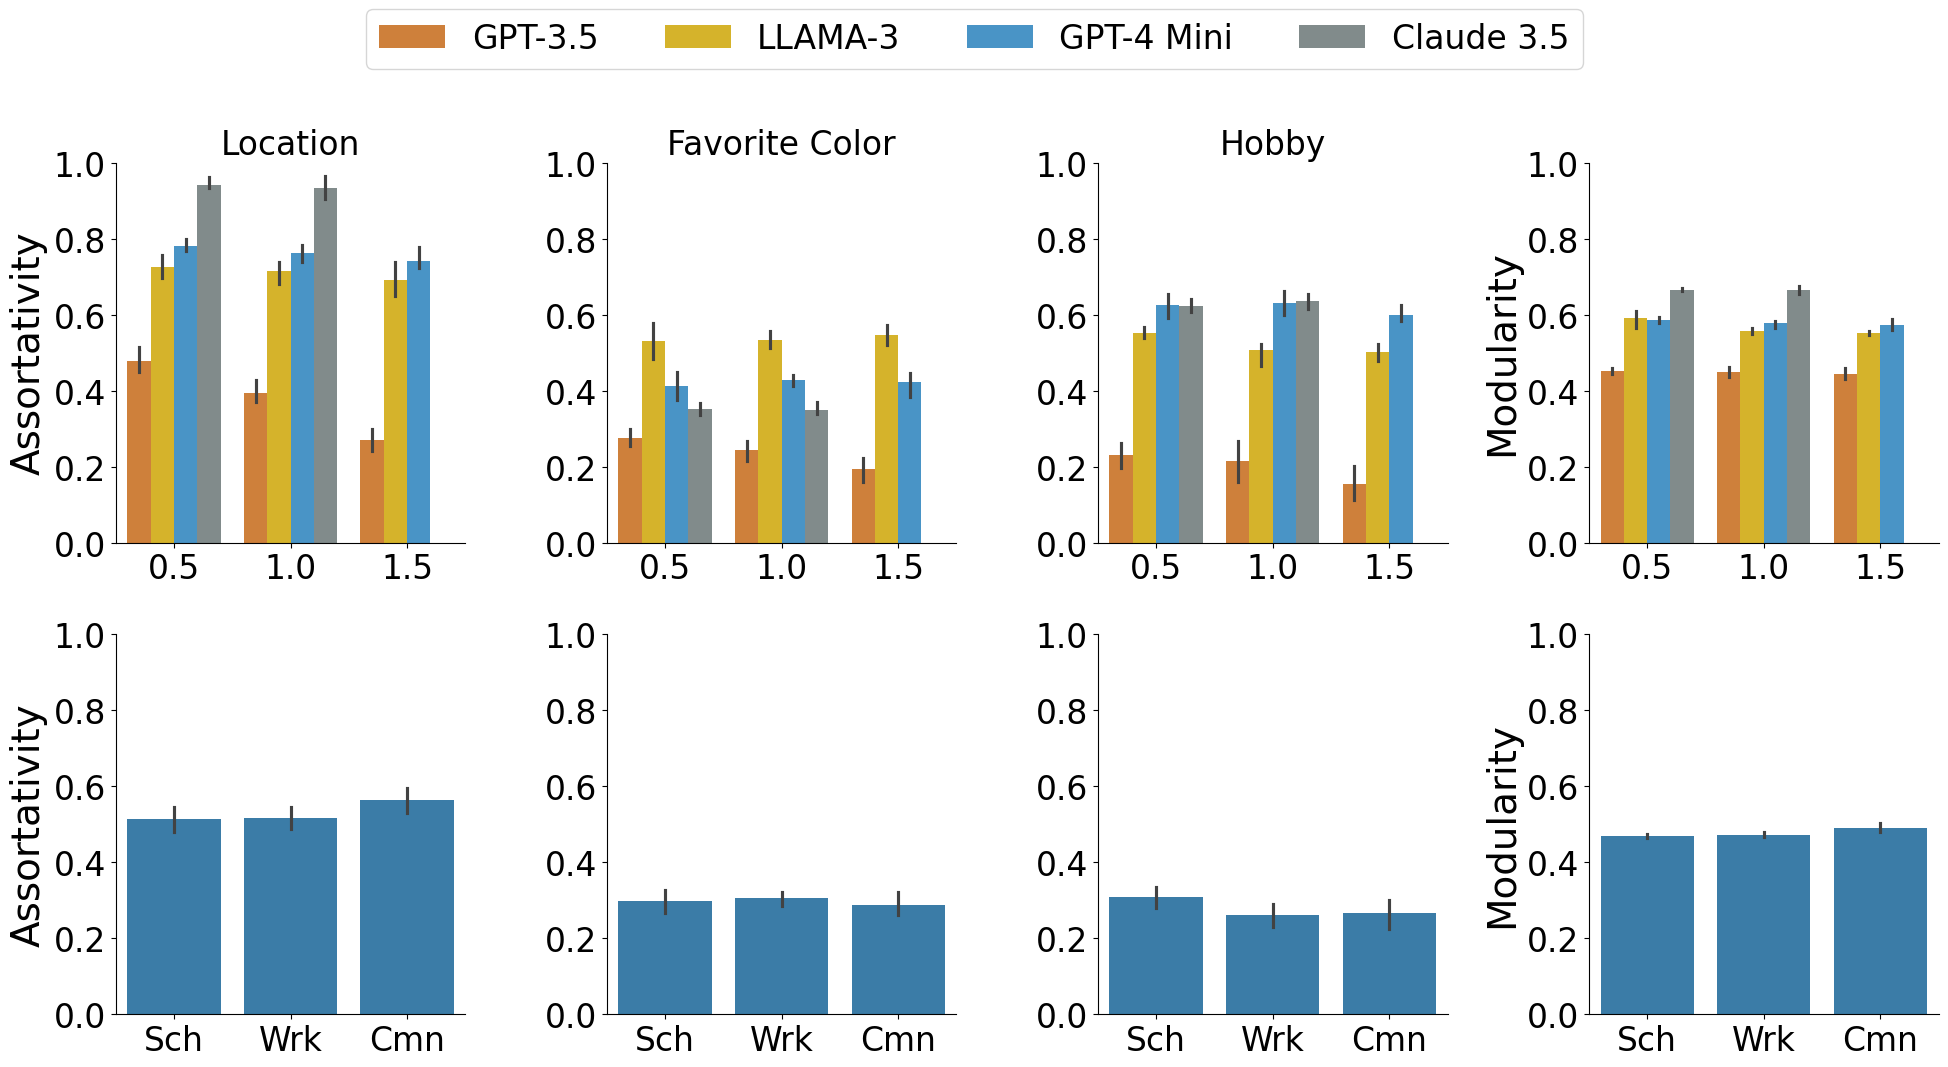

In [13]:
table_outfiles = []

for environment, role in zip(['school', 'work', 'community'], ['classmates', 'colleagues', 'neighbors']):
    outfile = f'outputs/principle_3_neighbors+gpt-3.5-turbo+{environment}.jsonl'
    run_network_formation_experiment(50, 50, 1, 10, outfile, [0.5], environment=environment, role=role, method='llm', model='gpt-3.5-turbo')

    table_outfiles.append(outfile)

for model in ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']:
    outfile = f'outputs/principle_3_neighbors+{model.replace("/", "-")}.jsonl'
    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0], environment=None, role='friends', method='llm', model=model)
    else:
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0, 1.5], environment=None, role='friends', method='llm', model=model)

    table_outfiles.append(outfile)

get_table(table_outfiles)

Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=1, temperature=1.0
Skipping simulation for n=50, i=1, temperature=1.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=2, temperature=1.0
Skipping simulation for n=50, i=2, temperature=1.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=3, temperature=1.0
Skipping simulation for n=50, i=3, temperature=1.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=4, temperature=1.0
Skipping simulation for n=50, i=4, temperature=1.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:800: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.330 (***)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_groupped.loc[(df_groupped['Temperature'] == temperature) & (df_groupped['Model'] == model), metric] = f'{df_groupped.loc[(df_groupped["Temperature"] == temperature) & (df_groupped["Model"] == model), metric].values[0]:.3f} ({p})'
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:800: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.150 (***)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_groupped.loc[(df_groupped['Temperature'] == temperature) & (df_groupped['Model'] == model), metric] = f'{df_groupped.loc[(df_group

attribute Location
attribute Hobby
attribute Favorite Color


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:883: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.barplot(data=df_baseline, y=y, x="Temperature", hue="Model", palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, i], orient='v', errorbar=('ci', ci_erorrorbar))
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:883: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.barplot(data=df_baseline, y=y, x="Temperature", hue="Model", palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, i], orient='v', errorbar=('ci', ci_erorrorbar))


attribute Lucky Number


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:893: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.barplot(data=df_communities_baseline, y='Modularity', x='Temperature', hue='Model', palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, len(attributes)])


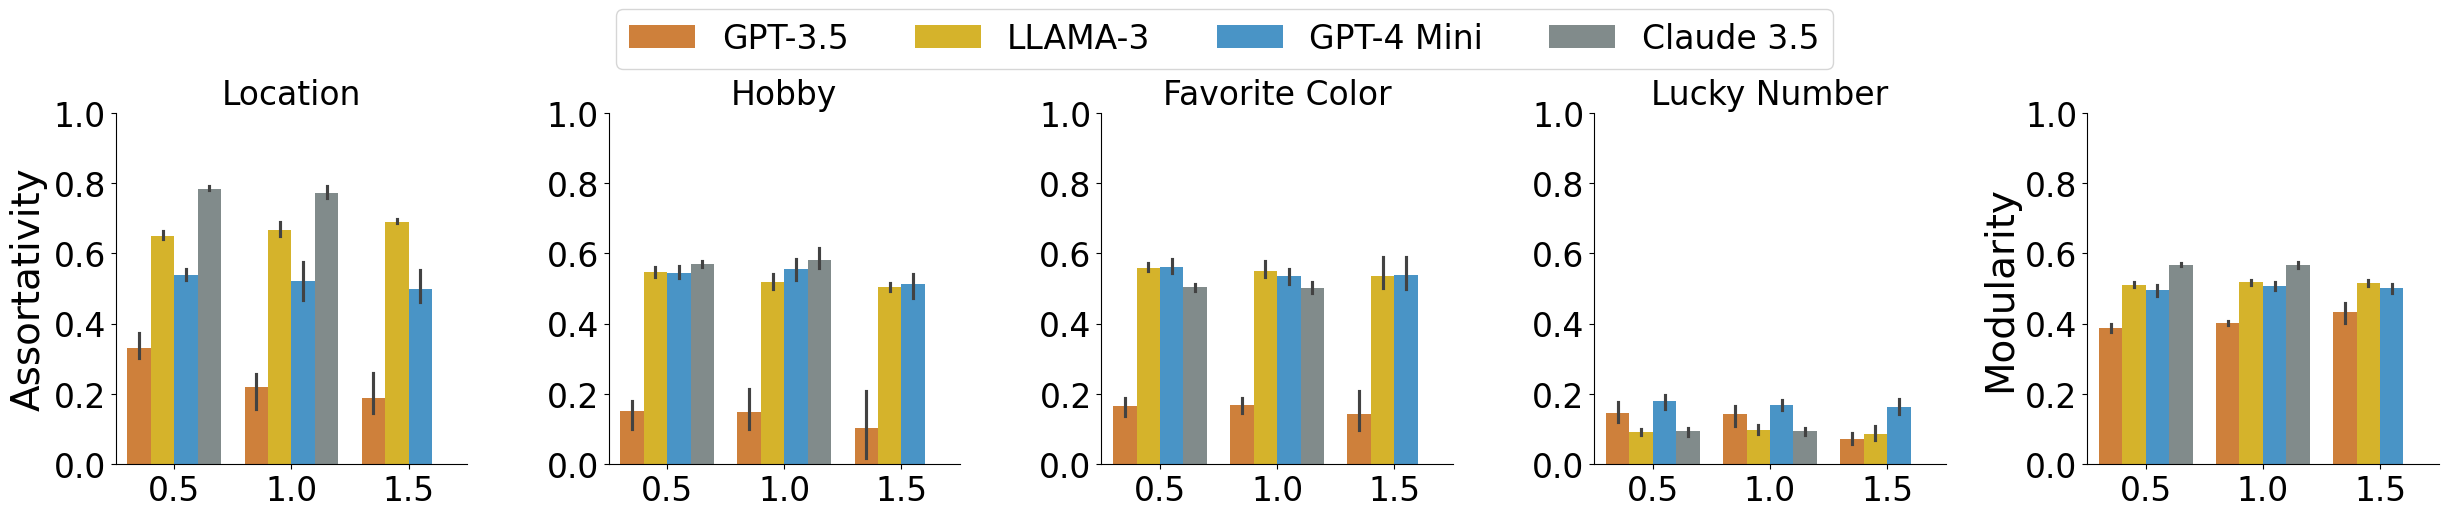

In [ ]:
table_outfiles_lucky_number = []

for model in ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']:
   
    outfile = f'outputs/principle_3_neighbors_lucky_number+{model.replace("/", "-")}.jsonl'

    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0], environment=None, role='friends', method='llm', model=model, profiles_filename='outputs/profiles_with_lucky_number.jsonl')
    else:
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0, 1.5], environment=None, role='friends', method='llm', model=model, profiles_filename='outputs/profiles_with_lucky_number.jsonl')

    table_outfiles_lucky_number.append(outfile)


# get_table(table_outfiles_no_color, attributes=['Location', 'Hobby'], environments=False, sfx='_no_color', profiles_filename='outputs/profiles_without_color.jsonl')
get_table(table_outfiles_lucky_number, attributes=['Location', 'Hobby', 'Favorite Color', 'Lucky Number'], environments=False, sfx='_lucky_number', profiles_filename='outputs/profiles_with_lucky_number.jsonl')


Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5


/Users/marios/miniconda3/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:800: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.485 (***)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_groupped.loc[(df_groupped['Temperature'] == temperature) & (df_groupped['Model'] == model), metric] = f'{df_groupped.loc[(df_groupped["Temperature"] == temperature) & (df_groupped["Model"] == model), metric].values[0]:.3f} ({p})'
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:800: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.295 (***)' has dtype incompatible with float

attribute Location
attribute Hobby
attribute Favorite Color


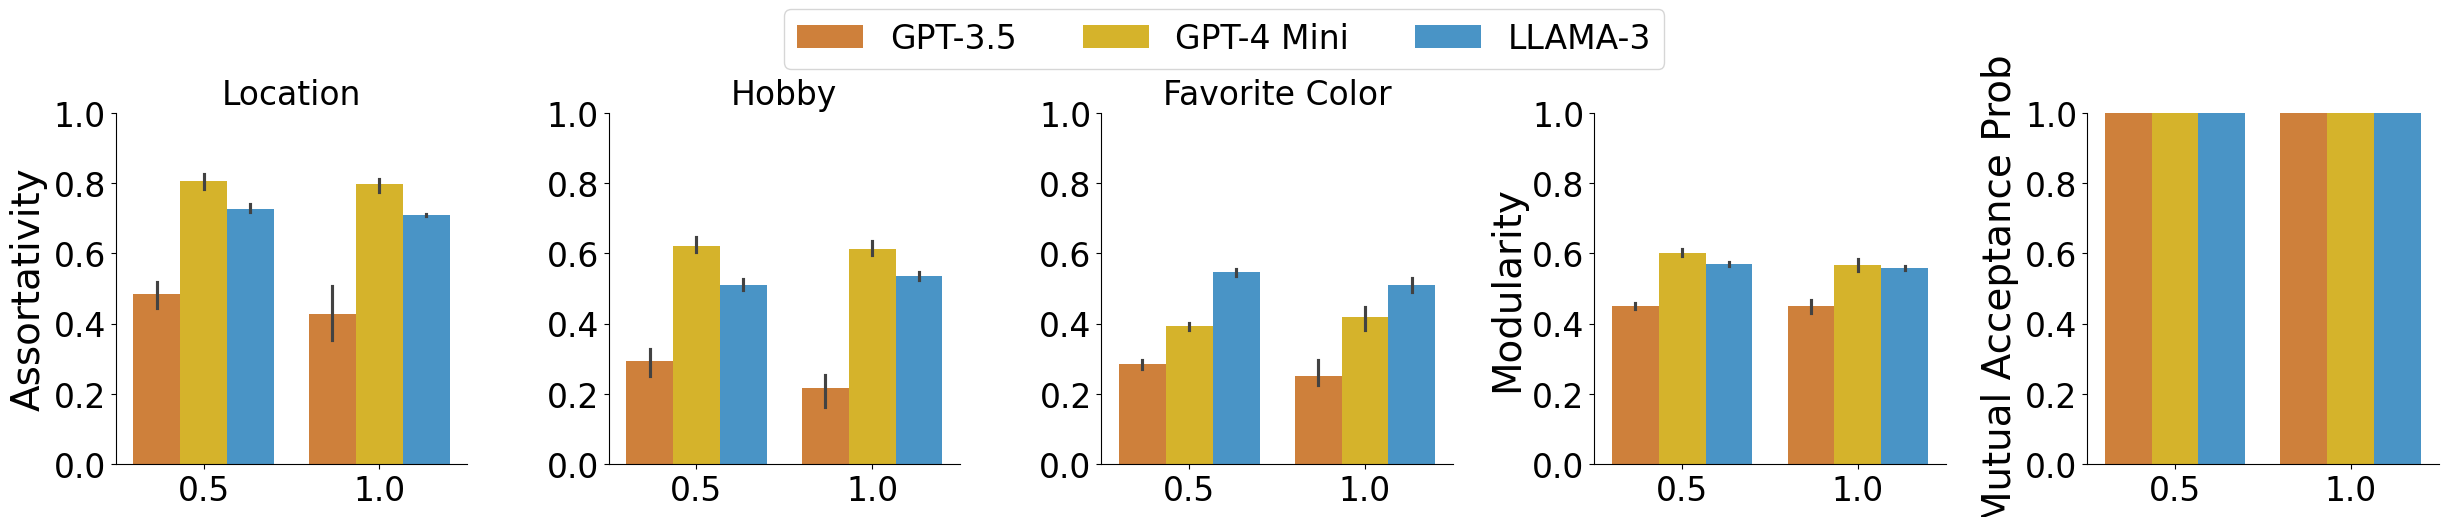

In [16]:
table_outfiles_mutual_acceptance = []

for model in ['gpt-3.5-turbo', 'gpt-4o-mini', 'meta/meta-llama-3-70b-instruct']:
    outfile = f'outputs/principle_3_neighbors_mutual_acceptance+{model.replace("/", "-")}.jsonl'
    run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5], environment=None, role='friends', method='llm', model=model, mutual_acceptance=True)

    table_outfiles_mutual_acceptance.append(outfile)


get_table(table_outfiles_mutual_acceptance, attributes=['Location', 'Hobby', 'Favorite Color'], environments=False, sfx='_mutual_acceptance', mutual_acceptance=True)

Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=1, temperature=1.0
Skipping simulation for n=50, i=1, temperature=1.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=2, temperature=1.0
Skipping simulation for n=50, i=2, temperature=1.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=3, temperature=1.0
Skipping simulation for n=50, i=3, temperature=1.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=4, temperature=1.0
Skipping simulation for n=50, i=4, temperature=1.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i

/Users/marios/miniconda3/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:800: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.494 (***)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_groupped.loc[(df_groupped['Temperature'] == temperature) & (df_groupped['Model'] == model), metric] = f'{df_groupped.loc[(df_groupped["Temperature"] == temperature) & (df_groupped["Model"] == model), metric].values[0]:.3f} ({p})'
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:800: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.372 (***)' has dtype incompatible with float

attribute Location
attribute Favorite Color
attribute Hobby


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:883: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.barplot(data=df_baseline, y=y, x="Temperature", hue="Model", palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, i], orient='v', errorbar=('ci', ci_erorrorbar))
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:893: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.barplot(data=df_communities_baseline, y='Modularity', x='Temperature', hue='Model', palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[0, len(attributes)])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_13885/1355004378.py:899: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

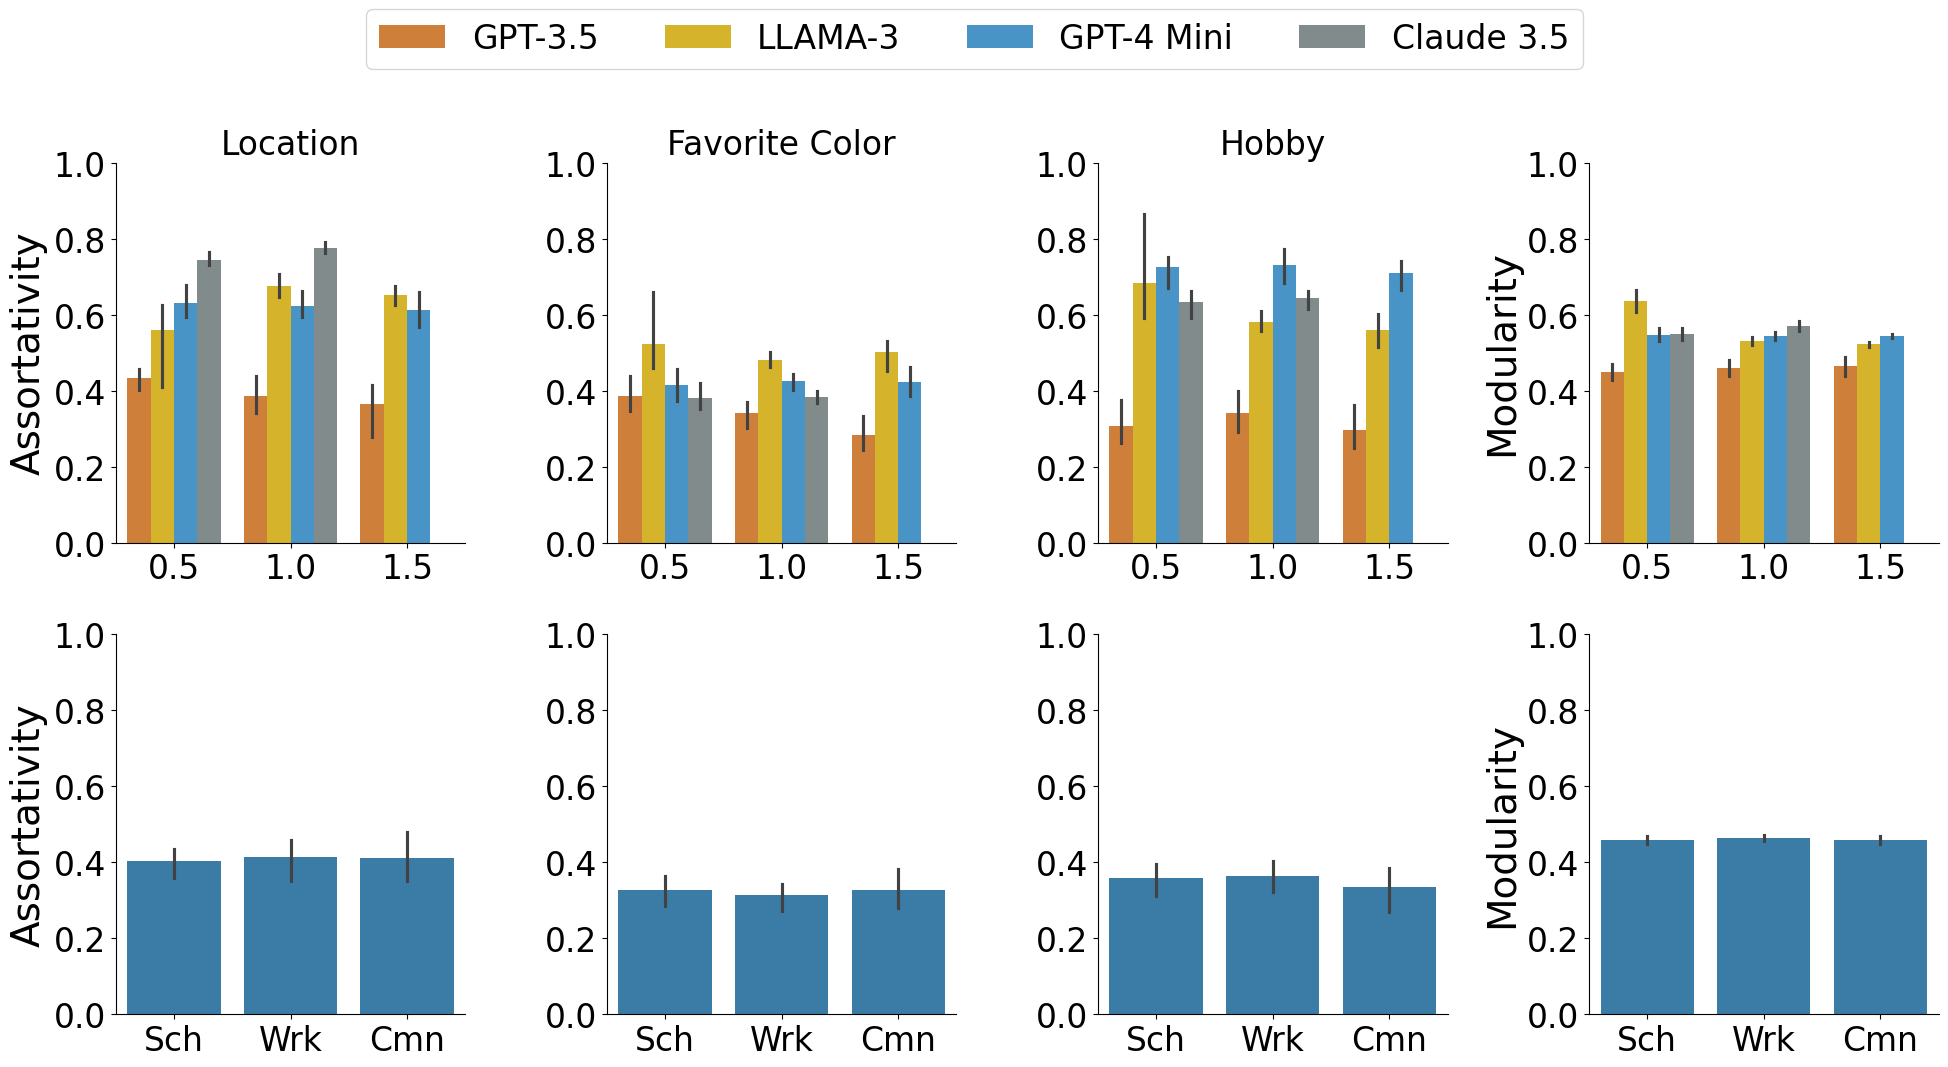

In [17]:
table_outfiles_cot = []

for environment, role in zip(['school', 'work', 'community'], ['classmates', 'colleagues', 'neighbors']):
    outfile = f'outputs/principle_3_neighbors+gpt-3.5-turbo+{environment}_cot.jsonl'
    run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0, 1.5], environment=environment, role=role, method='llm', model='gpt-3.5-turbo', cot=True)
    table_outfiles_cot.append(outfile)

for model in ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']:
    outfile = f'outputs/principle_3_neighbors+{model.replace("/", "-")}_cot.jsonl'

    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0], environment=None, role='friends', method='llm', model=model, cot=True)
    else:
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0, 1.5], environment=None, role='friends', method='llm', model=model, cot=True)
    
    table_outfiles_cot.append(outfile)

get_table(table_outfiles_cot, sfx="_cot", environments=True, mutual_acceptance=False, communities=True)